# Facial Expression Recognition

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

#Dataset: https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data

## Importing libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf

In [2]:
pip install --user numpy==1.21


Note: you may need to restart the kernel to use updated packages.


## Sample Image Visualization

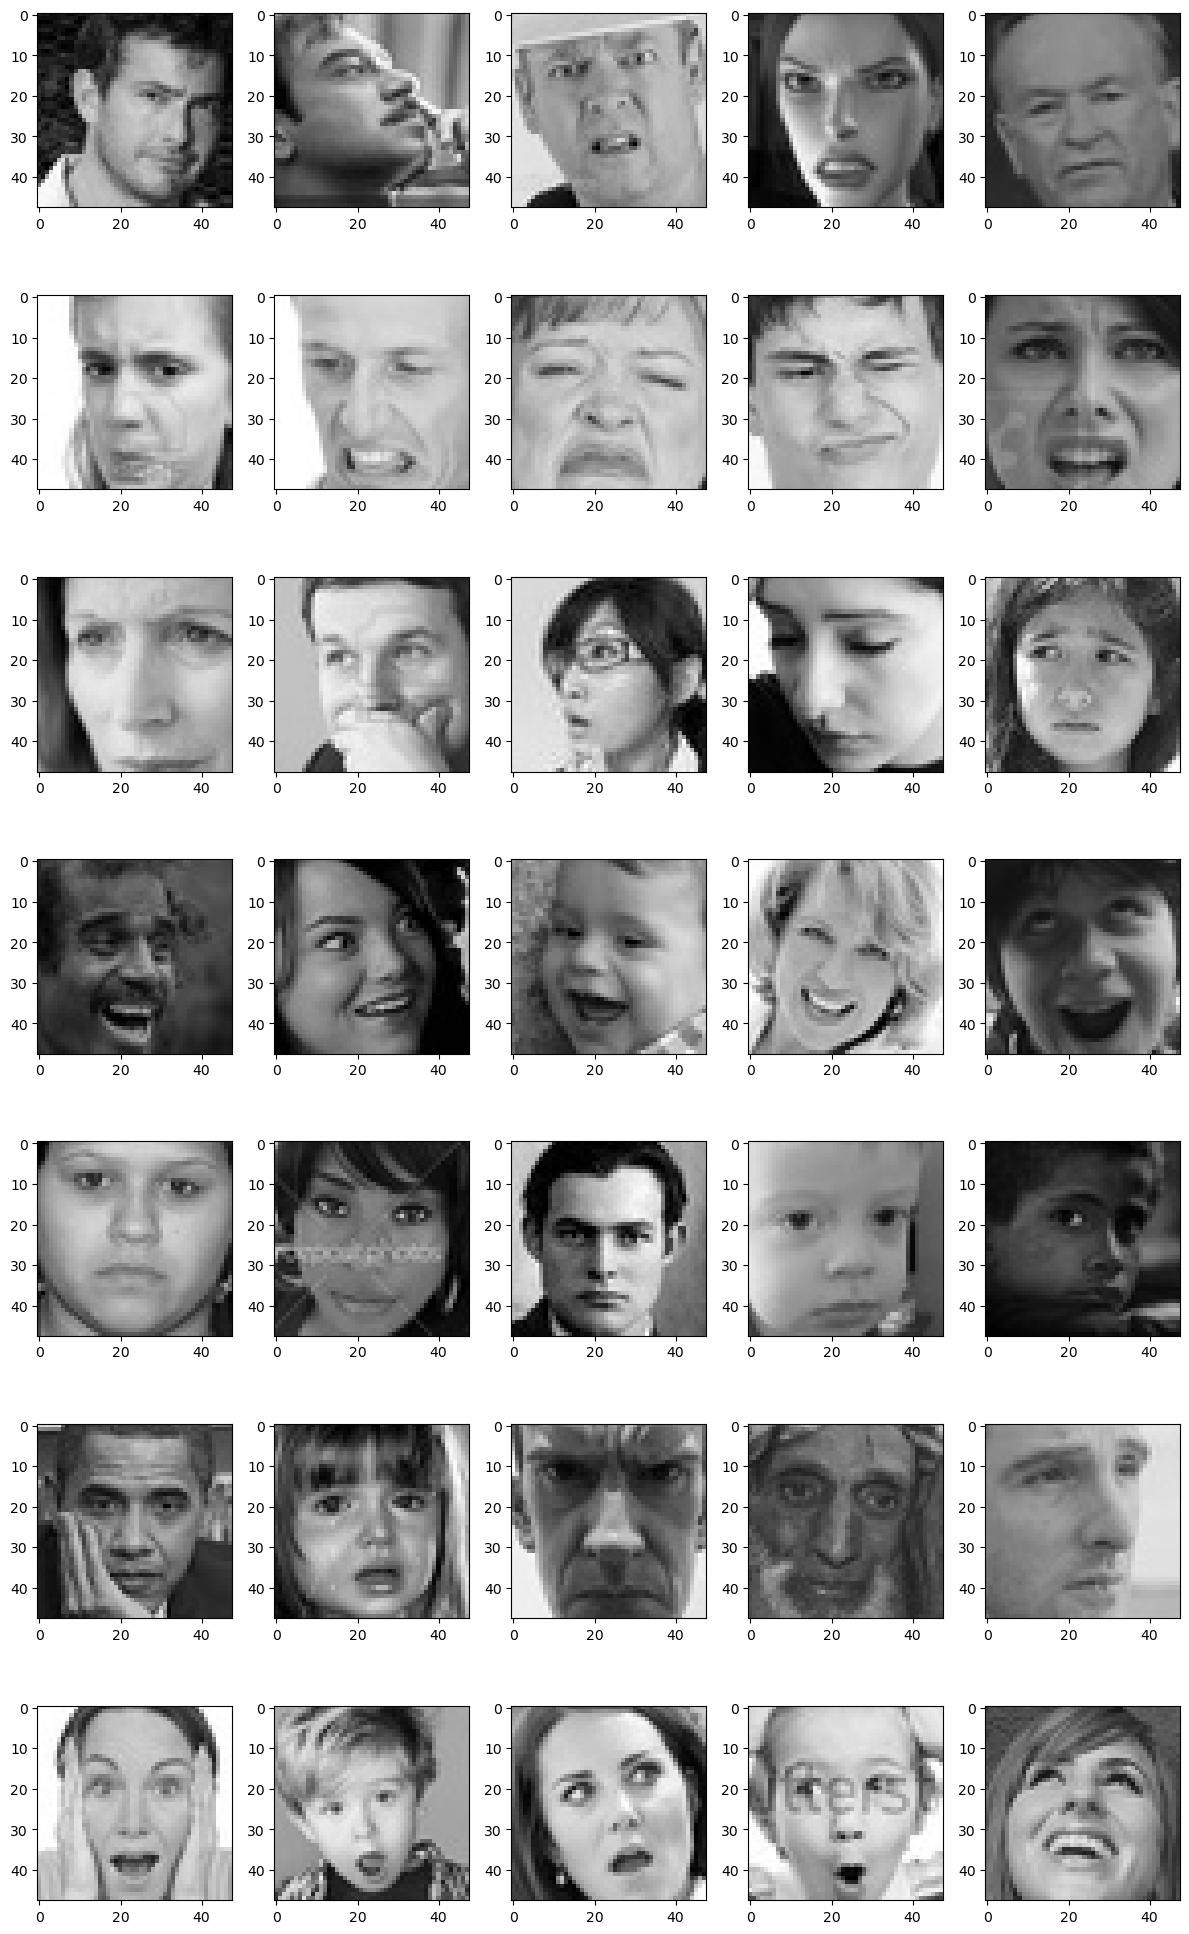

In [3]:
utils.datasets.fer.plot_example_images(plt).show()

In [4]:
# Checking the quantity of different expressions
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+ expression))) + " " +  expression + " images")

3994 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


## Generating Training and Validation Batches

In [5]:
img_size = 48
batch_size = 64

# Data Augmentation
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("train/", target_size=(img_size, img_size),color_mode="grayscale",
                                                   batch_size=batch_size, class_mode="categorical", shuffle=True)

Found 28708 images belonging to 7 classes.


In [6]:
# Validation
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("test/", target_size=(img_size, img_size),color_mode="grayscale",
                                                   batch_size=batch_size, class_mode="categorical")

Found 7178 images belonging to 7 classes.


## Creating Neural Network Model

In [7]:
model = Sequential()
# 1 - convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 - convolutional layer
model.add(Conv2D(filters=128, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 - convolutional layer
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4 - convolutional layer
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# 1 - Dense layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2 - Dense layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(7, activation="softmax"))



In [8]:
# Compiling model
model.compile(optimizer=Adam(learning_rate=0.005), loss= 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

## Training and evaluating model

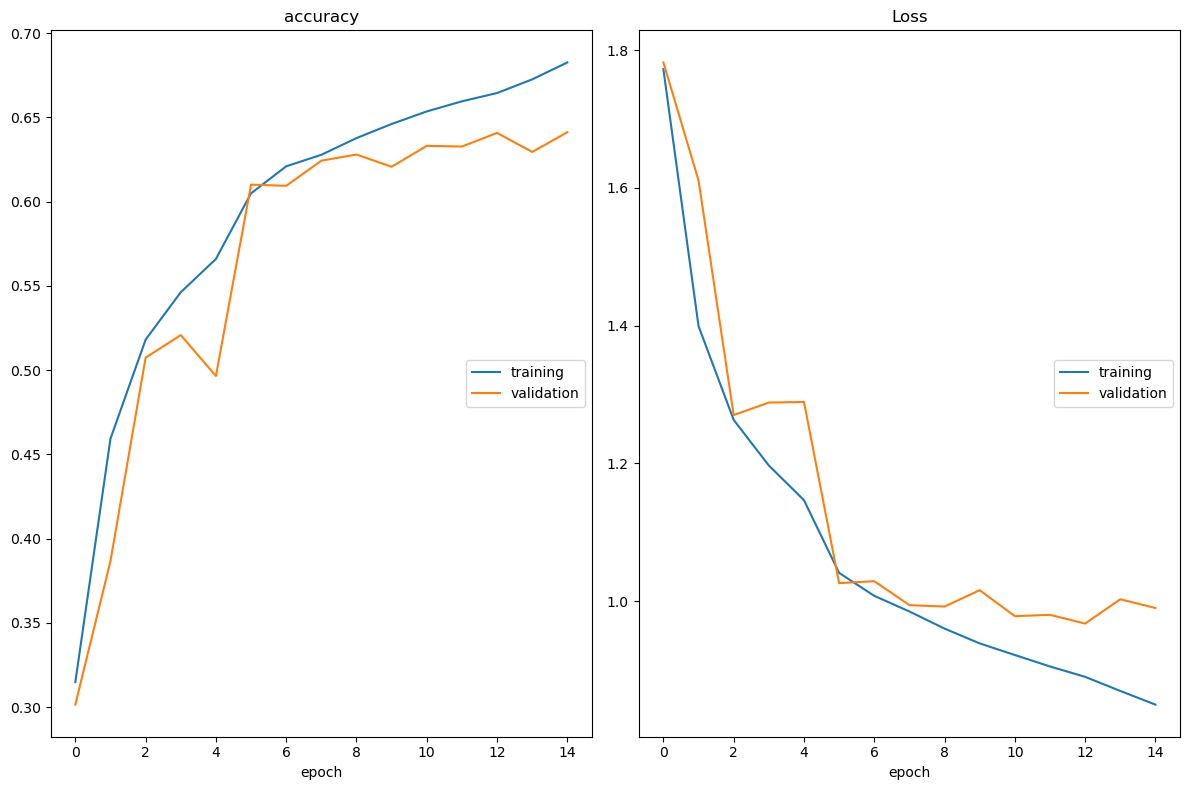

accuracy
	training         	 (min:    0.315, max:    0.683, cur:    0.683)
	validation       	 (min:    0.301, max:    0.641, cur:    0.641)
Loss
	training         	 (min:    0.850, max:    1.772, cur:    0.850)
	validation       	 (min:    0.967, max:    1.782, cur:    0.990)

Epoch 15: saving model to model_weight.h5
448/448 [==============================] - 334s 746ms/step - loss: 0.8497 - accuracy: 0.6826 - val_loss: 0.9900 - val_accuracy: 0.6412 - lr: 5.0000e-04


In [9]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weight.h5", monitor = 'val_accuracy', save_weights_only=True,
                            mode = 'max', verbose = 1 )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, min_lr = 1e-5, mode='auto')

callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks)

In [11]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)